# **Cancer Image Analysis Competition**

#### Shravan Venkatraman - 21BCE1200

#### **Note: This Notebook contains stages 1-3 of the competition. Stage 4 is in this notebook: Link**

#### **Link to the repository: https://github.com/shravan-18/Histopathological-Image-Analysis-Competition**

# **Steps 1, 2 - Load 500 samples from the training data and classify if images are cancerous or not**

## Import Dependencies for Image Classification

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
import random
import shutil

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))


from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model

2024-06-04 05:13:25.502808: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-04 05:13:25.502940: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-04 05:13:25.612831: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Number of devices: 1


In [3]:
df = pd.read_csv('/kaggle/input/hcd-cropped/train_labels.csv')
df.head()

id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

## Get Data Ready by Stratified Sampling

In [4]:
# Assuming df is your DataFrame with 'filename' and 'label' columns
total_samples = 500
class_counts = df['label'].value_counts()
samples_per_class = np.round(total_samples * class_counts / class_counts.sum()).astype(int)

# Perform stratified sampling
sampled_df = df.groupby('label').apply(lambda x: x.sample(samples_per_class[x.name])).reset_index(drop=True)
sampled_df

/tmp/ipykernel_35/2310470655.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('label').apply(lambda x: x.sample(samples_per_class[x.name])).reset_index(drop=True)


id  label
0    ace3c539402ed0d4e7f090284e97293d6c78f467      0
1    5869f10c86df0c6d4326c4034ba68deb59fbd816      0
2    d758a7bf984e4004eee93b00e42242d66b5e2f97      0
3    3e4ccbb9ed289f6a53a8596a1667f954bf7ae752      0
4    1d8f92ce0f951f9a13d4d010ec44ac6c6528afcc      0
..                                        ...    ...
495  af8504861a37fb2a95f555092cf359f93690f963      1
496  48c4e75d256383d654e2f25ded81e06d9e885059      1
497  f5c86ce90cce3a9dc1b198e613d70eb53150700a      1
498  260a6b7a4e365f546165dccba7dd44865b80fbcb      1
499  8b061145397ec6e25dfec112782700a3c9151e5a      1

[500 rows x 2 columns]

In [5]:
# Save the new DataFrame to a CSV file (optional)
sampled_df.to_csv('/kaggle/working/sampled_images_labels.csv', index=False)

In [ ]:
# !mkdir '/kaggle/working/train-sampled'
# !mkdir '/kaggle/working/train-sampled/0'
# !mkdir '/kaggle/working/train-sampled/1'

In [7]:
# Directory paths
source_dir = '/kaggle/input/hcd-cropped/train'
target_dir = '/kaggle/working/train-sampled'

# Iterate through the filenames in the sampled_df DataFrame
for _, row in sampled_df.iterrows():
    filename = row['id']
    
    # Add the.tif extension
    full_filename = filename + '.tif'
    
    # Construct the full source and target paths
    src_path = os.path.join(source_dir, full_filename)
    tgt_path = os.path.join(target_dir, str(row['label']), full_filename)
    
    # Copy the file
    shutil.copy(src_path, tgt_path)

In [8]:
for root, dirs, files in os.walk(target_dir, topdown=False):
    for name in files:
        # Check if the file has a.tif extension
        if os.path.splitext(name)[1].lower() == ".tif":
            # Construct the full path to the file
            filepath = os.path.join(root, name)
            
            # Check if a.jpg version of the file already exists
            jpg_filepath = os.path.splitext(filepath)[0] + ".jpg"
            if os.path.isfile(jpg_filepath):
                print("A JPEG file already exists for %s" % name)
            else:
                try:
                    # Open the.tif image
                    im = Image.open(filepath)
                    
                    # Convert and save as.jpg
                    im.save(jpg_filepath, "JPEG", quality=100)
                    
                    # Optionally, remove the original.tif file
                    os.remove(filepath)
                except Exception as e:
                    print(e)


## Data Loader and Augmentation

In [12]:
BATCH_SIZE = 64

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False, 
    validation_split=0.2,
)

train_data = train_datagen.flow_from_directory(
    directory=target_dir,
    target_size=(32, 32),
    class_mode='binary',
    batch_size=BATCH_SIZE,
    seed=42,
    subset="training",
)

val_data = train_datagen.flow_from_directory(
    directory=target_dir,
    target_size=(32, 32),
    class_mode='binary',
    batch_size=BATCH_SIZE,
    seed=42,
    subset="validation",
)

Found 401 images belonging to 2 classes.
Found 99 images belonging to 2 classes.


In [13]:
train_data.class_indices

{'0': 0, '1': 1}

In [14]:
val_data.class_indices

{'0': 0, '1': 1}

## Create Image Classification Model

In [19]:
def create_model(input_shape = (32, 32, 3)):

    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    
    for layer in base_model.layers:
        layer.trainable = False
        
    for layer in base_model.layers[-7:]:
        layer.trainable = True
    
    x = base_model.output
    x = L.GlobalAveragePooling2D()(x)
    Outputs = L.Dense(1, activation='sigmoid')(x)
    model = Model(base_model.input, Outputs, name="Model")
    
    model.compile(
        loss = "binary_crossentropy",
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=["accuracy"]
    )

    return model

In [20]:
with strategy.scope():
    model = create_model()
    
model.summary()

Model: "Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,715,201 (56.13 MB)

 Trainable params: 11,799,553 (45.01 MB)

 Non-trainable params: 2,915,648 (11.12 MB)

In [21]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=8)

## Train Image Classification Model

In [22]:
history = model.fit(train_data,
    epochs=32,
    validation_data = val_data,
    callbacks = [early_stopping]
)

Epoch 1/32
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.5074 - loss: 1.5315 - val_accuracy: 0.5960 - val_loss: 0.7496
Epoch 2/32
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.5826 - loss: 0.7237 - val_accuracy: 0.5960 - val_loss: 0.6995
Epoch 3/32
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.6050 - loss: 0.6928 - val_accuracy: 0.5960 - val_loss: 0.6848
Epoch 4/32
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.5862 - loss: 0.6797 - val_accuracy: 0.5960 - val_loss: 0.6640
Epoch 5/32
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.6218 - loss: 0.6432 - val_accuracy: 0.6869 - val_loss: 0.5961
Epoch 6/32
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.6860 - loss: 0.6154 - val_accuracy: 0.7172 - val_loss: 0.5617
Epoch 7/32
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.7175 - loss: 0.6229 - val_accuracy: 0.7374 - val_loss: 0.5456
Epoch 8/32
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.7182 - loss: 0.5717 - val_accuracy: 0.6970 - val_loss: 0.5826

In [23]:
# Plot the validation and training data separately
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

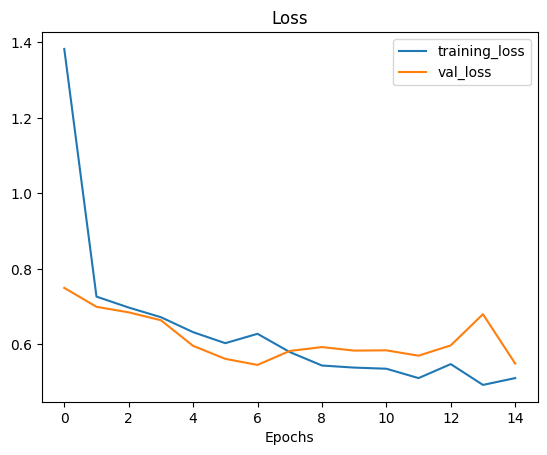

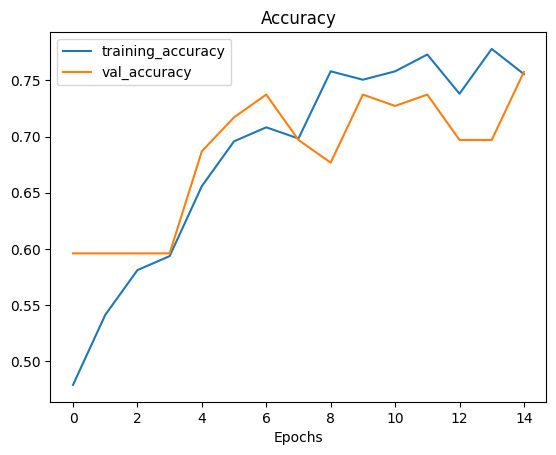

In [24]:
plot_loss_curves(history)

# **Step 3 - Generate Cancerous Images from Non-Cancerous Images**

## Import Dependencies for the GAN

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import shutil
from skimage import color

import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader

import torchvision
import torch.nn.functional as F

import glob
from torch.utils.data import Dataset
from PIL import Image

torch.manual_seed(0)

## Make a copy of the data by splitting into each class 

In [3]:
# !rm -r /kaggle/working/images
# !mkdir '/kaggle/working/train-sampled'
# !mkdir '/kaggle/working/train-sampled/0'
# !mkdir '/kaggle/working/train-sampled/1'
# !mkdir /kaggle/working/images

In [3]:
df = pd.read_csv('/kaggle/input/hcd-cropped/train_labels.csv')

# Directory paths
source_dir = '/kaggle/input/hcd-cropped/train'
target_dir = '/kaggle/working/train-sampled'

# Iterate through the filenames in the sampled_df DataFrame
for _, row in df.iterrows():
    filename = row['id']
    
    # Add the.tif extension
    full_filename = filename + '.tif'
    
    # Construct the full source and target paths
    src_path = os.path.join(source_dir, full_filename)
    tgt_path = os.path.join(target_dir, str(row['label']), full_filename)
    
    # Copy the file
    shutil.copy(src_path, tgt_path)

## Function to display GAN Progress during training

In [4]:
def show_and_save_tensor_images(image_tensor, num_images=25, size=(1, 32, 32), step=None, is_real=True, save_dir='/kaggle/working/images'):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_shifted = image_tensor
    image_unflat = image_shifted.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    
    # Save the image grid
    if is_real:
        filename = f'real_step_{step}.jpg'
    else:
        filename = f'fake_step_{step}.jpg'
    save_path = os.path.join(save_dir, filename)
    save_image(image_grid, save_path)
    
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

## Prepare Dataset 

In [5]:
class ImageDataset(Dataset):
    def __init__(self, root, transform=None):
        self.transform = transform
        self.files_A = sorted(glob.glob(root + '/' + '0' + '/*.*'))
        self.files_B = sorted(glob.glob(root + '/' + '1' + '/*.*'))
        if len(self.files_A) > len(self.files_B):
            self.files_A, self.files_B = self.files_B, self.files_A
        self.new_perm()
        assert len(self.files_A) > 0, "Make sure you downloaded the images!"

    def new_perm(self):
        self.randperm = torch.randperm(len(self.files_B))[:len(self.files_A)]

    def __getitem__(self, index):
        item_A = self.transform(Image.open(self.files_A[index % len(self.files_A)]))
        item_B = self.transform(Image.open(self.files_B[self.randperm[index]]))
        if item_A.shape[0] != 3:
            item_A = item_A.repeat(3, 1, 1)
        if item_B.shape[0] != 3:
            item_B = item_B.repeat(3, 1, 1)
        if index == len(self) - 1:
            self.new_perm()
        # Old versions of PyTorch didn't support normalization for different-channeled images
        return (item_A - 0.5) * 2, (item_B - 0.5) * 2

    def __len__(self):
        return min(len(self.files_A), len(self.files_B))

## GAN Functions

In [6]:
class ResidualBlock(nn.Module):
    '''
    ResidualBlock Class:
    Performs two convolutions and an instance normalization, the input is added
    to this output to form the residual block output.
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, input_channels, kernel_size=3, padding=1, padding_mode='reflect')
        self.conv2 = nn.Conv2d(input_channels, input_channels, kernel_size=3, padding=1, padding_mode='reflect')
        self.instancenorm = nn.InstanceNorm2d(input_channels)
        self.activation = nn.ReLU()

    def forward(self, x):
        '''
        Function for completing a forward pass of ResidualBlock:
        Given an image tensor, completes a residual block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        original_x = x.clone()
        x = self.conv1(x)
        x = self.instancenorm(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.instancenorm(x)
        return original_x + x

In [7]:
class ContractingBlock(nn.Module):
    '''
    ContractingBlock Class
    Performs a convolution followed by a max pool operation and an optional instance norm.
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels, use_bn=True, kernel_size=3, activation='relu'):
        super(ContractingBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, input_channels * 2, kernel_size=kernel_size, padding=1, stride=2, padding_mode='reflect')
        self.activation = nn.ReLU() if activation == 'relu' else nn.LeakyReLU(0.2)
        if use_bn:
            self.instancenorm = nn.InstanceNorm2d(input_channels * 2)
        self.use_bn = use_bn

    def forward(self, x):
        '''
        Function for completing a forward pass of ContractingBlock:
        Given an image tensor, completes a contracting block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x = self.conv1(x)
        if self.use_bn:
            x = self.instancenorm(x)
        x = self.activation(x)
        return x

In [8]:
class ExpandingBlock(nn.Module):
    '''
    ExpandingBlock Class:
    Performs a convolutional transpose operation in order to upsample,
        with an optional instance norm
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels, use_bn=True):
        super(ExpandingBlock, self).__init__()
        self.conv1 = nn.ConvTranspose2d(input_channels, input_channels // 2, kernel_size=3, stride=2, padding=1, output_padding=1)
        if use_bn:
            self.instancenorm = nn.InstanceNorm2d(input_channels // 2)
        self.use_bn = use_bn
        self.activation = nn.ReLU()

    def forward(self, x):
        '''
        Function for completing a forward pass of ExpandingBlock:
        Given an image tensor, completes an expanding block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
            skip_con_x: the image tensor from the contracting path (from the opposing block of x)
                    for the skip connection
        '''
        x = self.conv1(x)
        if self.use_bn:
            x = self.instancenorm(x)
        x = self.activation(x)
        return x

In [9]:
class FeatureMapBlock(nn.Module):
    '''
    FeatureMapBlock Class
    The final layer of a Generator -
    maps each the output to the desired number of output channels
    Values:
        input_channels: the number of channels to expect from a given input
        output_channels: the number of channels to expect for a given output
    '''
    def __init__(self, input_channels, output_channels):
        super(FeatureMapBlock, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=7, padding=3, padding_mode='reflect')

    def forward(self, x):
        '''
        Function for completing a forward pass of FeatureMapBlock:
        Given an image tensor, returns it mapped to the desired number of channels.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x = self.conv(x)
        return x

## Generator

In [10]:
class Generator(nn.Module):
    '''
    Generator Class
    A series of 2 contracting blocks, 9 residual blocks, and 2 expanding blocks to
    transform an input image into an image from the other class, with an upfeature
    layer at the start and a downfeature layer at the end.
    Values:
        input_channels: the number of channels to expect from a given input
        output_channels: the number of channels to expect for a given output
    '''
    def __init__(self, input_channels, output_channels, hidden_channels=64):
        super(Generator, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels)
        self.contract2 = ContractingBlock(hidden_channels * 2)
        res_mult = 4
        self.res0 = ResidualBlock(hidden_channels * res_mult)
        self.res1 = ResidualBlock(hidden_channels * res_mult)
        self.res2 = ResidualBlock(hidden_channels * res_mult)
        self.res3 = ResidualBlock(hidden_channels * res_mult)
        self.res4 = ResidualBlock(hidden_channels * res_mult)
        self.res5 = ResidualBlock(hidden_channels * res_mult)
        self.res6 = ResidualBlock(hidden_channels * res_mult)
        self.res7 = ResidualBlock(hidden_channels * res_mult)
        self.res8 = ResidualBlock(hidden_channels * res_mult)
        self.expand2 = ExpandingBlock(hidden_channels * 4)
        self.expand3 = ExpandingBlock(hidden_channels * 2)
        self.downfeature = FeatureMapBlock(hidden_channels, output_channels)
        self.tanh = torch.nn.Tanh()

    def forward(self, x):
        '''
        Function for completing a forward pass of Generator:
        Given an image tensor, passes it through the U-Net with residual blocks
        and returns the output.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.res0(x2)
        x4 = self.res1(x3)
        x5 = self.res2(x4)
        x6 = self.res3(x5)
        x7 = self.res4(x6)
        x8 = self.res5(x7)
        x9 = self.res6(x8)
        x10 = self.res7(x9)
        x11 = self.res8(x10)
        x12 = self.expand2(x11)
        x13 = self.expand3(x12)
        xn = self.downfeature(x13)
        return self.tanh(xn)

## Discriminator

In [11]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Structured like the contracting path of the U-Net, the discriminator will
    output a matrix of values classifying corresponding portions of the image as real or fake.
    Parameters:
        input_channels: the number of image input channels
        hidden_channels: the initial number of discriminator convolutional filters
    '''
    def __init__(self, input_channels, hidden_channels=64):
        super(Discriminator, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels, use_bn=False, kernel_size=4, activation='lrelu')
        self.contract2 = ContractingBlock(hidden_channels * 2, kernel_size=4, activation='lrelu')
        self.contract3 = ContractingBlock(hidden_channels * 4, kernel_size=4, activation='lrelu')
        self.final = nn.Conv2d(hidden_channels * 8, 1, kernel_size=1)

    def forward(self, x):
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        xn = self.final(x3)
        return xn

## Dataloader and Training Attributes

In [12]:
adv_criterion = nn.MSELoss()
recon_criterion = nn.L1Loss()

n_epochs = 32
dim_A = 3
dim_B = 3
display_step = 2000
batch_size = 8
lr = 0.0002
load_shape = 32
target_shape = 32
device = 'cuda'

"""You will then load the images of the dataset while introducing some data augmentation (e.g. crops and random horizontal flips)."""
transform = transforms.Compose([
    transforms.Resize(load_shape),
    transforms.RandomCrop(target_shape),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

dataset = ImageDataset('/kaggle/working/train-sampled', transform=transform)

In [13]:
gen_AB = Generator(dim_A, dim_B).to(device)
gen_BA = Generator(dim_B, dim_A).to(device)
gen_opt = torch.optim.Adam(list(gen_AB.parameters()) + list(gen_BA.parameters()), lr=lr, betas=(0.5, 0.999))
disc_A = Discriminator(dim_A).to(device)
disc_A_opt = torch.optim.Adam(disc_A.parameters(), lr=lr, betas=(0.5, 0.999))
disc_B = Discriminator(dim_B).to(device)
disc_B_opt = torch.optim.Adam(disc_B.parameters(), lr=lr, betas=(0.5, 0.999))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

# Feel free to change pretrained to False if you're training the model from scratch
pretrained = False
if pretrained:
    pre_dict = torch.load('cycleGAN_100000.pth')
    gen_AB.load_state_dict(pre_dict['gen_AB'])
    gen_BA.load_state_dict(pre_dict['gen_BA'])
    gen_opt.load_state_dict(pre_dict['gen_opt'])
    disc_A.load_state_dict(pre_dict['disc_A'])
    disc_A_opt.load_state_dict(pre_dict['disc_A_opt'])
    disc_B.load_state_dict(pre_dict['disc_B'])
    disc_B_opt.load_state_dict(pre_dict['disc_B_opt'])
else:
    gen_AB = gen_AB.apply(weights_init)
    gen_BA = gen_BA.apply(weights_init)
    disc_A = disc_A.apply(weights_init)
    disc_B = disc_B.apply(weights_init)


## GAN Losses

In [14]:
def get_disc_loss(real_X, fake_X, disc_X, adv_criterion):
    '''
    Return the loss of the discriminator given inputs.
    Parameters:
        real_X: the real images from pile X
        fake_X: the generated images of class X
        disc_X: the discriminator for class X; takes images and returns real/fake class X
            prediction matrices
        adv_criterion: the adversarial loss function; takes the discriminator
            predictions and the target labels and returns a adversarial
            loss (which you aim to minimize)
    '''
    #### START CODE HERE ####
    disc_fake_X_hat = disc_X(fake_X.detach()) # Detach generator
    disc_fake_X_loss = adv_criterion(disc_fake_X_hat, torch.zeros_like(disc_fake_X_hat))
    disc_real_X_hat = disc_X(real_X)
    disc_real_X_loss = adv_criterion(disc_real_X_hat, torch.ones_like(disc_real_X_hat))
    disc_loss = (disc_fake_X_loss + disc_real_X_loss) / 2
    #### END CODE HERE ####
    return disc_loss

# UNIT TEST
test_disc_X = lambda x: x * 97
test_real_X = torch.tensor(83.)
test_fake_X = torch.tensor(89.)
test_adv_criterion = lambda x, y: x * 79 + y * 73
assert torch.abs((get_disc_loss(test_real_X, test_fake_X, test_disc_X, test_adv_criterion)) - 659054.5000) < 1e-6
test_disc_X = lambda x: x.mean(0, keepdim=True)
test_adv_criterion = torch.nn.BCEWithLogitsLoss()
test_input = torch.ones(20, 10)
# If this runs, it's a pass - checks that the shapes are treated correctly
get_disc_loss(test_input, test_input, test_disc_X, test_adv_criterion)
print("Success!")

Success!


In [15]:
def get_gen_adversarial_loss(real_X, disc_Y, gen_XY, adv_criterion):
    '''
    Return the adversarial loss of the generator given inputs
    (and the generated images for testing purposes).
    Parameters:
        real_X: the real images from pile X
        disc_Y: the discriminator for class Y; takes images and returns real/fake class Y
            prediction matrices
        gen_XY: the generator for class X to Y; takes images and returns the images
            transformed to class Y
        adv_criterion: the adversarial loss function; takes the discriminator
                  predictions and the target labels and returns a adversarial
                  loss (which you aim to minimize)
    '''
    #### START CODE HERE ####
    fake_Y = gen_XY(real_X)
    disc_fake_Y_hat = disc_Y(fake_Y)
    adversarial_loss = adv_criterion(disc_fake_Y_hat, torch.ones_like(disc_fake_Y_hat))
    #### END CODE HERE ####
    return adversarial_loss, fake_Y

# UNIT TEST
test_disc_Y = lambda x: x * 97
test_real_X = torch.tensor(83.)
test_gen_XY = lambda x: x * 89
test_adv_criterion = lambda x, y: x * 79 + y * 73
test_res = get_gen_adversarial_loss(test_real_X, test_disc_Y, test_gen_XY, test_adv_criterion)
assert torch.abs(test_res[0] - 56606652) < 1e-6
assert torch.abs(test_res[1] - 7387) < 1e-6
test_disc_Y = lambda x: x.mean(0, keepdim=True)
test_adv_criterion = torch.nn.BCEWithLogitsLoss()
test_input = torch.ones(20, 10)
# If this runs, it's a pass - checks that the shapes are treated correctly
get_gen_adversarial_loss(test_input, test_disc_Y, test_gen_XY, test_adv_criterion)
print("Success!")

Success!


In [16]:
def get_identity_loss(real_X, gen_YX, identity_criterion):
    '''
    Return the identity loss of the generator given inputs
    (and the generated images for testing purposes).
    Parameters:
        real_X: the real images from pile X
        gen_YX: the generator for class Y to X; takes images and returns the images
            transformed to class X
        identity_criterion: the identity loss function; takes the real images from X and
                        those images put through a Y->X generator and returns the identity
                        loss (which you aim to minimize)
    '''
    #### START CODE HERE ####
    identity_X = gen_YX(real_X)
    identity_loss = identity_criterion(identity_X, real_X)
    #### END CODE HERE ####
    return identity_loss, identity_X

# UNIT TEST
test_real_X = torch.tensor(83.)
test_gen_YX = lambda x: x * 89
test_identity_criterion = lambda x, y: (x + y) * 73
test_res = get_identity_loss(test_real_X, test_gen_YX, test_identity_criterion)
assert torch.abs(test_res[0] - 545310) < 1e-6
assert torch.abs(test_res[1] - 7387) < 1e-6
print("Success!")

Success!


In [17]:
def get_cycle_consistency_loss(real_X, fake_Y, gen_YX, cycle_criterion):
    '''
    Return the cycle consistency loss of the generator given inputs
    (and the generated images for testing purposes).
    Parameters:
        real_X: the real images from pile X
        fake_Y: the generated images of class Y
        gen_YX: the generator for class Y to X; takes images and returns the images
            transformed to class X
        cycle_criterion: the cycle consistency loss function; takes the real images from X and
                        those images put through a X->Y generator and then Y->X generator
                        and returns the cycle consistency loss (which you aim to minimize)
    '''
    #### START CODE HERE ####
    cycle_X = gen_YX(fake_Y)
    cycle_loss = cycle_criterion(cycle_X, real_X)
    #### END CODE HERE ####
    return cycle_loss, cycle_X

# UNIT TEST
test_real_X = torch.tensor(83.)
test_fake_Y = torch.tensor(97.)
test_gen_YX = lambda x: x * 89
test_cycle_criterion = lambda x, y: (x + y) * 73
test_res = get_cycle_consistency_loss(test_real_X, test_fake_Y, test_gen_YX, test_cycle_criterion)
assert torch.abs(test_res[1] - 8633) < 1e-6
assert torch.abs(test_res[0] - 636268) < 1e-6
print("Success!")

Success!


In [18]:
def get_gen_loss(real_A, real_B, gen_AB, gen_BA, disc_A, disc_B, adv_criterion, identity_criterion, cycle_criterion, lambda_identity=0.1, lambda_cycle=10):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        real_A: the real images from pile A
        real_B: the real images from pile B
        gen_AB: the generator for class A to B; takes images and returns the images
            transformed to class B
        gen_BA: the generator for class B to A; takes images and returns the images
            transformed to class A
        disc_A: the discriminator for class A; takes images and returns real/fake class A
            prediction matrices
        disc_B: the discriminator for class B; takes images and returns real/fake class B
            prediction matrices
        adv_criterion: the adversarial loss function; takes the discriminator
            predictions and the true labels and returns a adversarial
            loss (which you aim to minimize)
        identity_criterion: the reconstruction loss function used for identity loss
            and cycle consistency loss; takes two sets of images and returns
            their pixel differences (which you aim to minimize)
        cycle_criterion: the cycle consistency loss function; takes the real images from X and
            those images put through a X->Y generator and then Y->X generator
            and returns the cycle consistency loss (which you aim to minimize).
            Note that in practice, cycle_criterion == identity_criterion == L1 loss
        lambda_identity: the weight of the identity loss
        lambda_cycle: the weight of the cycle-consistency loss
    '''
    # Hint 1: Make sure you include both directions - you can think of the generators as collaborating
    # Hint 2: Don't forget to use the lambdas for the identity loss and cycle loss!
    #### START CODE HERE ####
    # Adversarial Loss -- get_gen_adversarial_loss(real_X, disc_Y, gen_XY, adv_criterion)
    adv_loss_BA, fake_A = get_gen_adversarial_loss(real_B, disc_A, gen_BA, adv_criterion)
    adv_loss_AB, fake_B = get_gen_adversarial_loss(real_A, disc_B, gen_AB, adv_criterion)
    gen_adversarial_loss = adv_loss_BA + adv_loss_AB

    # Identity Loss -- get_identity_loss(real_X, gen_YX, identity_criterion)
    identity_loss_A, identity_A = get_identity_loss(real_A, gen_BA, identity_criterion)
    identity_loss_B, identity_B = get_identity_loss(real_B, gen_AB, identity_criterion)
    gen_identity_loss = identity_loss_A + identity_loss_B

    # Cycle-consistency Loss -- get_cycle_consistency_loss(real_X, fake_Y, gen_YX, cycle_criterion)
    cycle_loss_BA, cycle_A = get_cycle_consistency_loss(real_A, fake_B, gen_BA, cycle_criterion)
    cycle_loss_AB, cycle_B = get_cycle_consistency_loss(real_B, fake_A, gen_AB, cycle_criterion)
    gen_cycle_loss = cycle_loss_BA + cycle_loss_AB

    # Total loss
    gen_loss = lambda_identity * gen_identity_loss + lambda_cycle * gen_cycle_loss + gen_adversarial_loss
    #### END CODE HERE ####
    return gen_loss, fake_A, fake_B

# UNIT TEST
test_real_A = torch.tensor(97)
test_real_B = torch.tensor(89)
test_gen_AB = lambda x: x * 83
test_gen_BA = lambda x: x * 79
test_disc_A = lambda x: x * 47
test_disc_B = lambda x: x * 43
test_adv_criterion = lambda x, y: x * 73 + y * 71
test_recon_criterion = lambda x, y: (x + y) * 61
test_lambda_identity = 59
test_lambda_cycle = 53
test_res = get_gen_loss(
    test_real_A,
    test_real_B,
    test_gen_AB,
    test_gen_BA,
    test_disc_A,
    test_disc_B,
    test_adv_criterion,
    test_recon_criterion,
    test_recon_criterion,
    test_lambda_identity,
    test_lambda_cycle)
assert test_res[0].item() == 4047804560
assert test_res[1].item() == 7031
assert test_res[2].item() == 8051
print("Success!")

Success!


## Train Model (took a lot of time so ran for more epochs on AMD Cloud GPU - Final Results for the same are in the repository mentioned above)

#### The GAN was trained for 128 epochs on AMD Cloud and the results are in the respository @ AMD-Cloud-Runs/CycleGAN/CycleGAN_images

#### The weights for the trained GAN are available at: https://drive.google.com/file/d/1krtR7ej2fCu6bXPzAfokILP6v_jyfhmU/view?usp=sharing

In [19]:
"""
## CycleGAN Training
"""
plt.rcParams["figure.figsize"] = (4, 4)


def train(save_model=True):
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    cur_step = 0

    for epoch in range(n_epochs):
        # Dataloader returns the batches
        # for image, _ in tqdm(dataloader):
        for real_A, real_B in tqdm(dataloader):
            # real_A -> Non-Cancerous Images
            # real_B -> Cancerous Images

            # image_width = image.shape[3]
            real_A = nn.functional.interpolate(real_A, size=target_shape)
            real_B = nn.functional.interpolate(real_B, size=target_shape)
            cur_batch_size = len(real_A)
            real_A = real_A.to(device)
            real_B = real_B.to(device)

            ### Update discriminator A ###
            disc_A_opt.zero_grad() # Zero out the gradient before backpropagation
            with torch.no_grad():
                fake_A = gen_BA(real_B)
            disc_A_loss = get_disc_loss(real_A, fake_A, disc_A, adv_criterion)
            disc_A_loss.backward(retain_graph=True) # Update gradients
            disc_A_opt.step() # Update optimizer

            ### Update discriminator B ###
            disc_B_opt.zero_grad() # Zero out the gradient before backpropagation
            with torch.no_grad():
                fake_B = gen_AB(real_A)
            disc_B_loss = get_disc_loss(real_B, fake_B, disc_B, adv_criterion)
            disc_B_loss.backward(retain_graph=True) # Update gradients
            disc_B_opt.step() # Update optimizer

            ### Update generator ###
            gen_opt.zero_grad()
            gen_loss, fake_A, fake_B = get_gen_loss(
                real_A, real_B, gen_AB, gen_BA, disc_A, disc_B, adv_criterion, recon_criterion, recon_criterion
            )
            gen_loss.backward() # Update gradients
            gen_opt.step() # Update optimizer

            # Keep track of the average discriminator loss
            mean_discriminator_loss += disc_A_loss.item() / display_step
            # Keep track of the average generator loss
            mean_generator_loss += gen_loss.item() / display_step

            ### Visualization code ###
            if cur_step % display_step == 0:
                print(f"Epoch {epoch}: Step {cur_step}: Generator (U-Net) loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}")
                show_and_save_tensor_images(torch.cat([real_A, real_B]), size=(dim_A, target_shape, target_shape), step=cur_step, is_real=True)
                show_and_save_tensor_images(torch.cat([fake_B, fake_A]), size=(dim_B, target_shape, target_shape), step=cur_step, is_real=False)
                mean_generator_loss = 0
                mean_discriminator_loss = 0
                # You can change save_model to True if you'd like to save the model
                if save_model:
                    torch.save({
                        'gen_AB': gen_AB.state_dict(),
                        'gen_BA': gen_BA.state_dict(),
                        'gen_opt': gen_opt.state_dict(),
                        'disc_A': disc_A.state_dict(),
                        'disc_A_opt': disc_A_opt.state_dict(),
                        'disc_B': disc_B.state_dict(),
                        'disc_B_opt': disc_B_opt.state_dict()
                    }, f"/kaggle/working/cycleGAN_{cur_step}.pth")
            cur_step += 1

  0%|          | 0/11140 [00:00<?, ?it/s]

Epoch 0: Step 0: Generator (U-Net) loss: 0.007357259750366211, Discriminator loss: 0.0002772023677825928


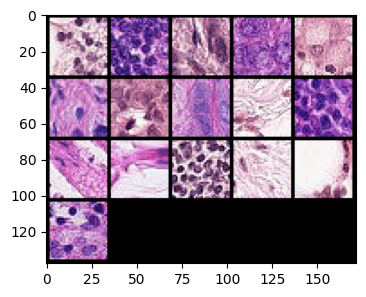

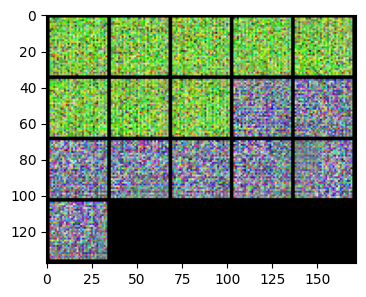

Epoch 0: Step 2000: Generator (U-Net) loss: 5.9662227206230165, Discriminator loss: 0.2355920328944919


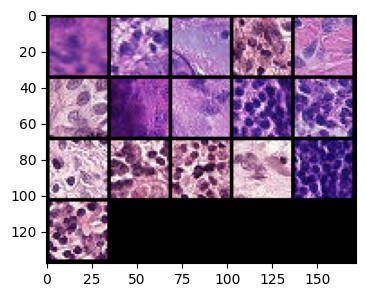

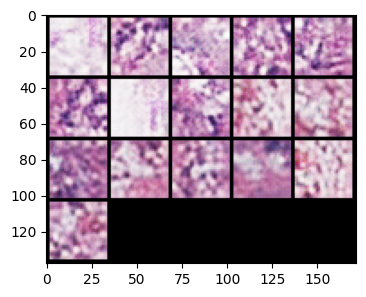

Epoch 0: Step 4000: Generator (U-Net) loss: 5.019563091039668, Discriminator loss: 0.19362996762990933


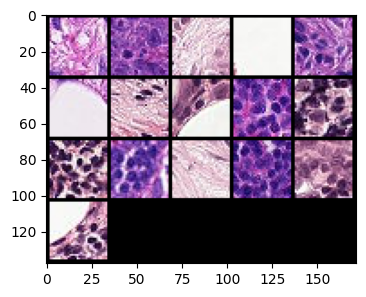

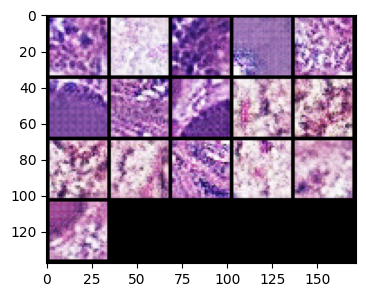

Epoch 0: Step 6000: Generator (U-Net) loss: 4.693538034796716, Discriminator loss: 0.17837812588363883


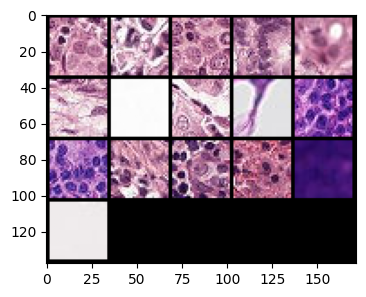

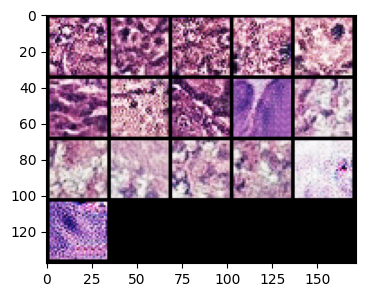

Epoch 0: Step 8000: Generator (U-Net) loss: 4.458044620871544, Discriminator loss: 0.15155733967013646


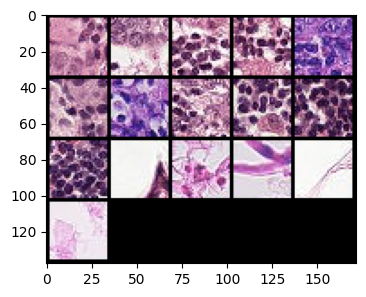

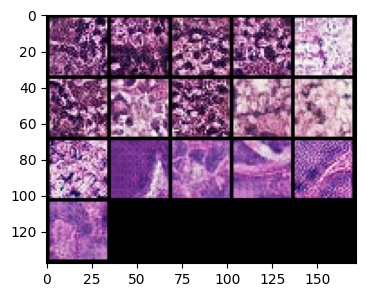

Epoch 0: Step 10000: Generator (U-Net) loss: 4.223119988560674, Discriminator loss: 0.15680509147234287


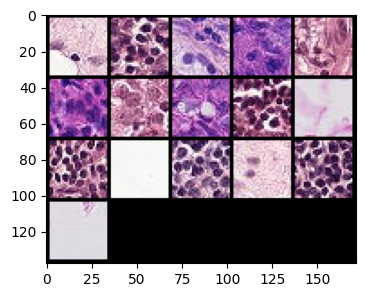

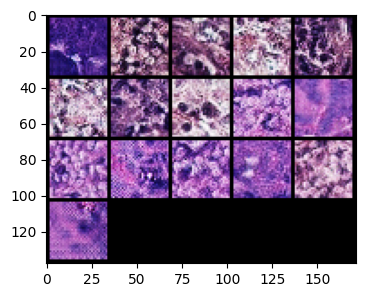

  0%|          | 0/11140 [00:00<?, ?it/s]

Epoch 1: Step 12000: Generator (U-Net) loss: 3.9650198065042557, Discriminator loss: 0.17315593382343566


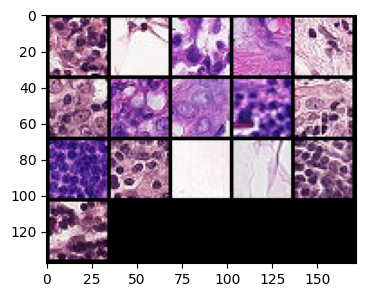

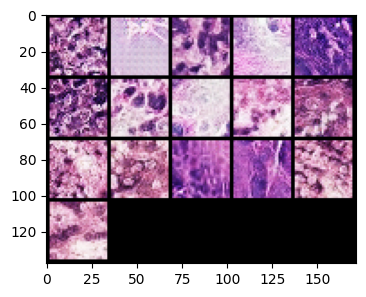

Epoch 1: Step 14000: Generator (U-Net) loss: 3.934539066314697, Discriminator loss: 0.15743798608891685


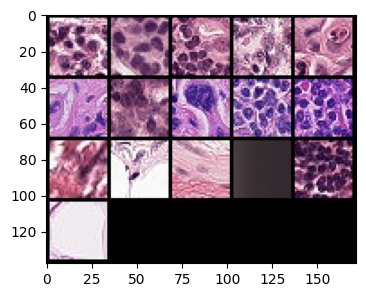

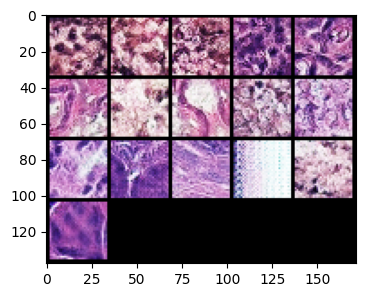

Epoch 1: Step 16000: Generator (U-Net) loss: 3.859998497486121, Discriminator loss: 0.1546722053904086


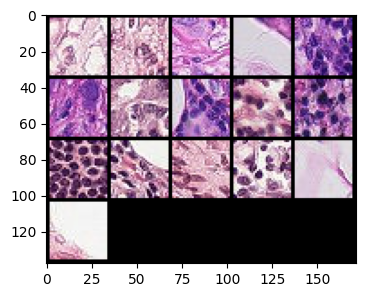

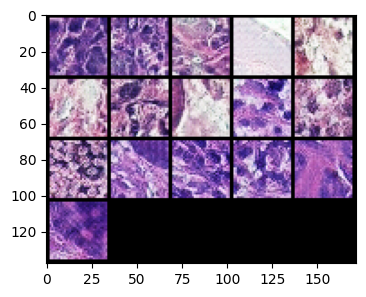

Epoch 1: Step 18000: Generator (U-Net) loss: 3.7907647278308887, Discriminator loss: 0.16855242056027026


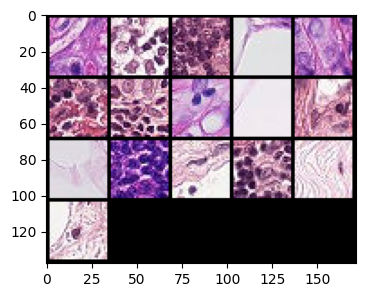

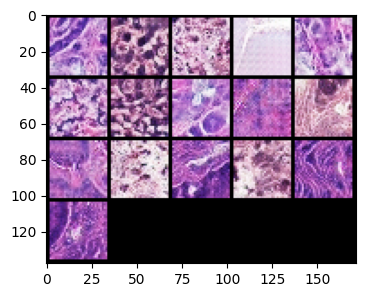

Epoch 1: Step 20000: Generator (U-Net) loss: 3.723152010798452, Discriminator loss: 0.173734073076397


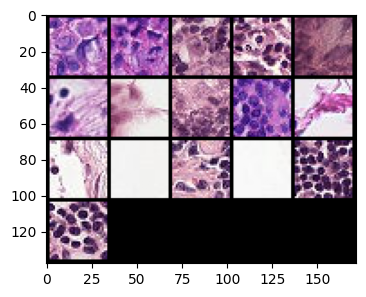

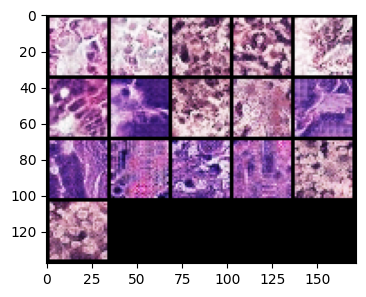

Epoch 1: Step 22000: Generator (U-Net) loss: 3.615916955709456, Discriminator loss: 0.18158457493223246


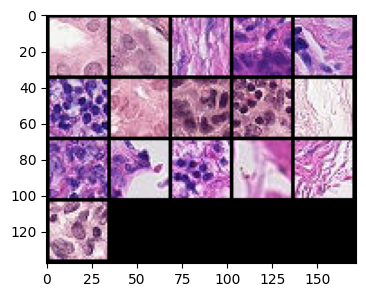

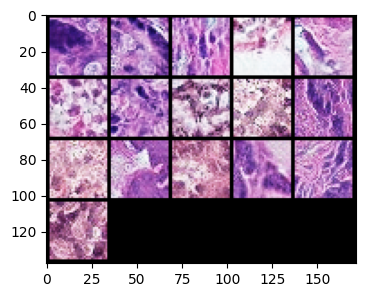

  0%|          | 0/11140 [00:00<?, ?it/s]

Epoch 2: Step 24000: Generator (U-Net) loss: 3.594006482124325, Discriminator loss: 0.18111002473160615


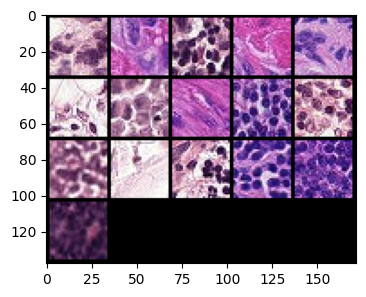

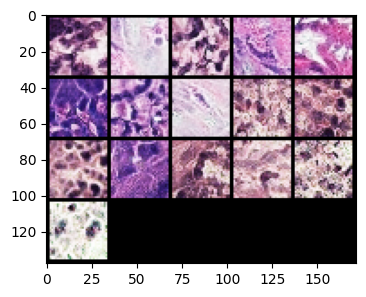

Epoch 2: Step 26000: Generator (U-Net) loss: 3.5575896396636955, Discriminator loss: 0.17638750495202846


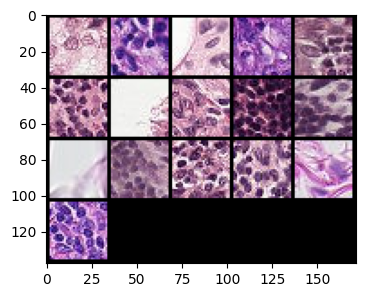

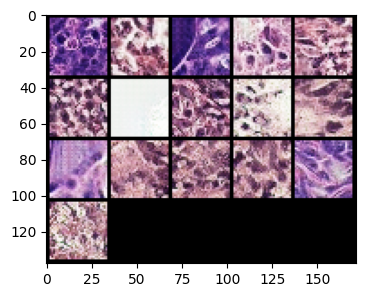

Epoch 2: Step 28000: Generator (U-Net) loss: 3.591046417832373, Discriminator loss: 0.1706385183725504


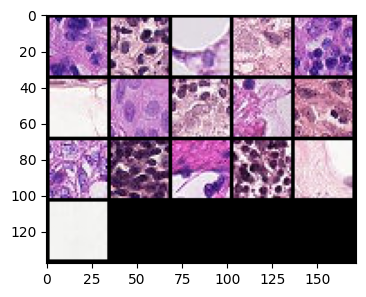

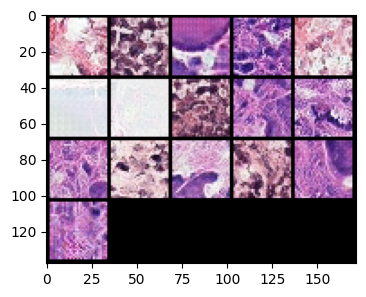

Epoch 2: Step 30000: Generator (U-Net) loss: 3.63482161021233, Discriminator loss: 0.1267187193669378


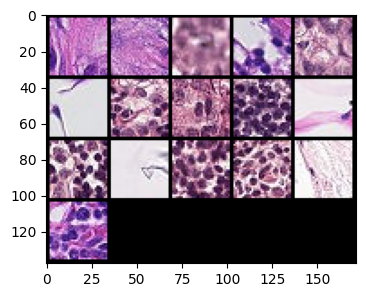

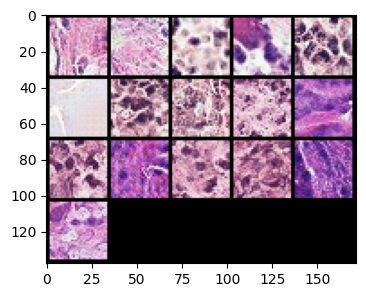

Epoch 2: Step 32000: Generator (U-Net) loss: 3.697706775546065, Discriminator loss: 0.12099428290314974


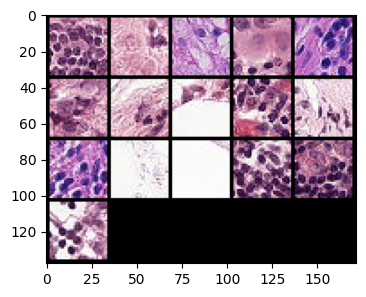

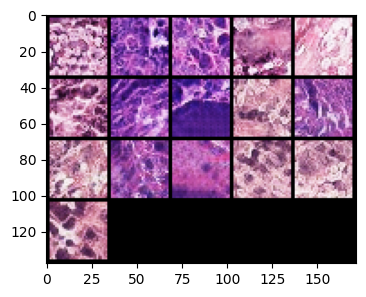

  0%|          | 0/11140 [00:00<?, ?it/s]

Epoch 3: Step 34000: Generator (U-Net) loss: 3.643967679023747, Discriminator loss: 0.1227849057503044


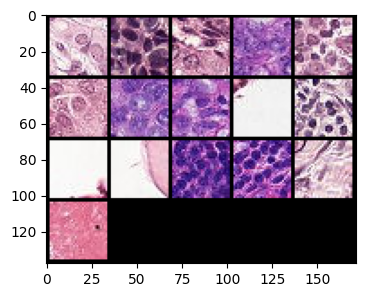

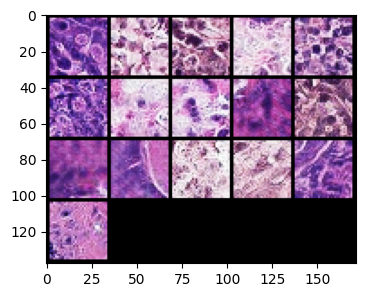

Epoch 3: Step 36000: Generator (U-Net) loss: 3.6510121654272067, Discriminator loss: 0.12155130449309946


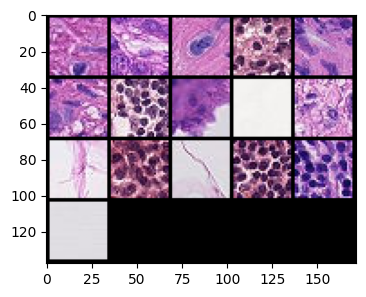

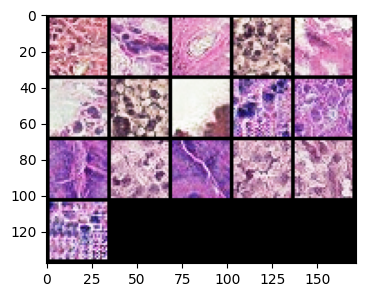

Epoch 3: Step 38000: Generator (U-Net) loss: 3.6848565667867668, Discriminator loss: 0.11761574305035177


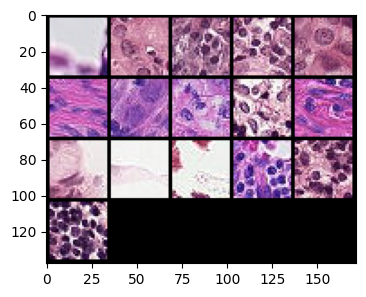

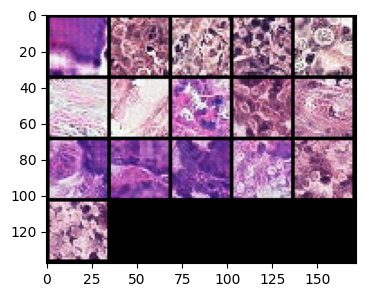

Epoch 3: Step 40000: Generator (U-Net) loss: 3.6971337689161303, Discriminator loss: 0.11122449705190976


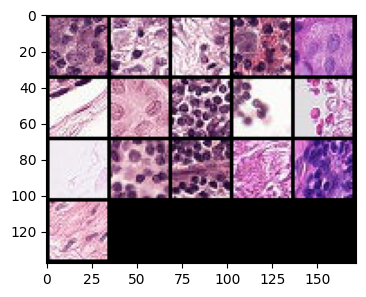

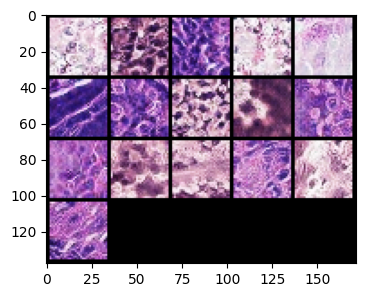

Epoch 3: Step 42000: Generator (U-Net) loss: 3.649617631196969, Discriminator loss: 0.10958090491406615


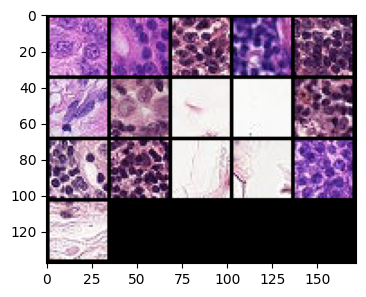

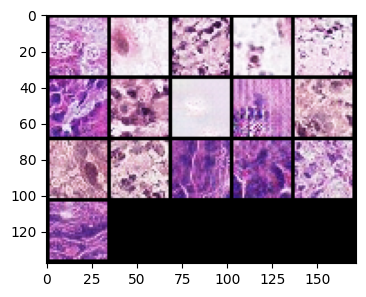

Epoch 3: Step 44000: Generator (U-Net) loss: 3.6848684195280033, Discriminator loss: 0.10244079381413743


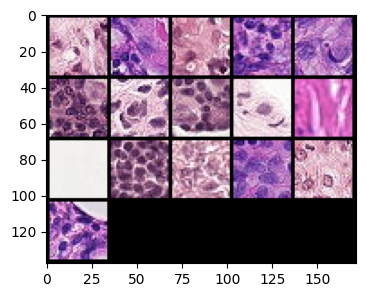

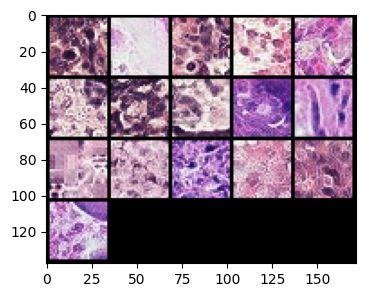

  0%|          | 0/11140 [00:00<?, ?it/s]

Epoch 4: Step 46000: Generator (U-Net) loss: 3.7149145419597636, Discriminator loss: 0.09438751754723494


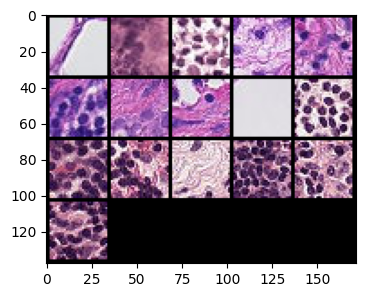

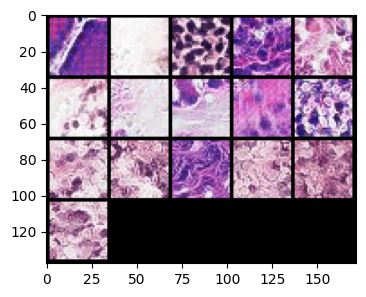

Epoch 4: Step 48000: Generator (U-Net) loss: 3.6624888525009207, Discriminator loss: 0.0960174362752586


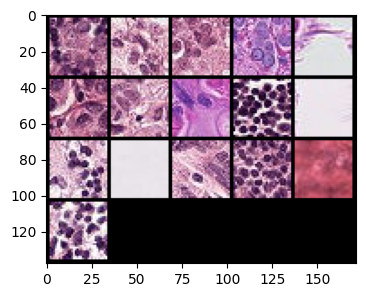

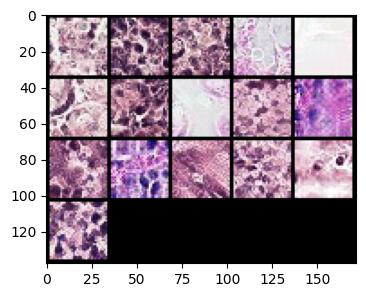

In [ ]:
train()

# **Step 4 - Utilize Graph Convolutional Networks (GCNs) to Analyze Nucleus Features**

In [ ]:
# Refer Next Notebook